<center><h1>Diode leads resistance from a quench event</h1></center>

# 0. Initialise the working environment
## 0.1. Import useful packages

In [1]:
import pytimber
ldb = pytimber.LoggingDB()
import matplotlib.pyplot as plt

from lhcsmapi.analysis.diode.DiodeLeadResistanceQuery import DiodeLeadResistanceQuery
from lhcsmapi.analysis.diode.DiodeLeadResistanceAnalysis import DiodeLeadResistanceAnalysis
from lhcsmapi.analysis.diode.DiodeLeadResistancePlot import DiodeLeadResistancePlot

from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from lhcsmapi.Time import Time
from lhcsmapi.dbsignal.post_mortem.PmDbRequest import PmDbRequest

# 1. Get user input

In [2]:
use_case = input("Please, select use case: 1 (MQ.25R4 (RQD)) or 2 (MB.B9R1) =>")
use_case = use_case or '1'
print('Chosen case: ', use_case)
if use_case == '1':
    # Event 1 - MQ.25R4 (RQD)
    magnet = input("Magnet Name? [25R4]:")
    magnet = magnet or '25R4'
    circuit_name = input("Circuit Name? [RQD.A45]:")
    circuit_name = circuit_name or 'RQD.A45'
    circuit_type = circuit_name.split('.')[0][0:2]
    timestamp_iqps_qh = input("iQPS QH PM Time Stamp? [2018-12-09 09:55:47.668]:")
    timestamp_iqps_qh = timestamp_iqps_qh or '2018-12-09 09:55:47.668'
else:
    # Event 2 - MB.B9R1
    magnet = input("Magnet Name? [B9R1]:")
    magnet = magnet or 'B9R1'
    circuit_name = input("Circuit Name? [RB.A12]:")
    circuit_name = circuit_name or 'RB.A12'
    circuit_type = circuit_name.split('.')[0]
    timestamp_iqps_qh = input("iQPS QH PM Time Stamp? [2018-12-12 17:21:35.371]:")
    timestamp_iqps_qh = timestamp_iqps_qh or '2018-12-12 17:21:35.371'
#
print("-----")
print("Circuit=", circuit_type, "Sector=", circuit_name, "Magnet=", magnet)
print("Time stamp (iQPS)=", timestamp_iqps_qh)
#
# 25R4, RQD/RQF.A45, 2018-12-09 09:55:47.668, B26R4, dt = 0 - default for option 1
# 32L3, RQD/RQF.A23, 2018-07-19 15:19:17.699, B33L3 - very noisy event!
# 29L8, RQD/RQF.A78, 2016-06-06 08:34:33.667, B30L8
# 30R8, RQD/RQF.A81, 2018-12-03 15:21:05.372, B31R8, dt = 0
#
# B9R1, RB.A12, 2018-12-12 17:21:35.371, B11R1, dt = -0.51; - default for option 2
# A21R7, RB.A78, 2018-12-08 18:42:39.890, B21R7, dt = -76; - very surprising time stamp of nQPS!!!
# A26R1, RB.A12, 2018-12-09 06:20:54.729, B26R1, dt = xxx; - max at the end of EE-decay!?
# A31R1, RB.A12, 2018-12-12 17:21:34.793, B31R1

Please, select use case: 1 (MQ.25R4 (RQD)) or 2 (MB.B9R1) =>
Chosen case:  1
Magnet Name? [25R4]:
Circuit Name? [RQD.A45]:
iQPS QH PM Time Stamp? [2018-12-09 09:55:47.668]:
-----
Circuit= RQ Sector= RQD.A45 Magnet= 25R4
Time stamp (iQPS)= 2018-12-09 09:55:47.668


# 2. CALS
# 2.1. Calculate Resistance

In [3]:
magnet_type, I_MEAS, U_DIODE = DiodeLeadResistanceQuery.get_magnet_type_i_meas_u_diode(magnet, circuit_name)
        
i_circuit_sync = DiodeLeadResistanceQuery.query_cals_signal(I_MEAS, timestamp_iqps_qh, magnet_type, ldb=ldb)
u_diode_sync = DiodeLeadResistanceQuery.query_cals_signal(U_DIODE, timestamp_iqps_qh, magnet_type, ldb=ldb)
        
u_diode = DiodeLeadResistanceAnalysis.calculate_resistance_cals(magnet, circuit_name, i_circuit_sync, u_diode_sync)

## 2.2. Plot

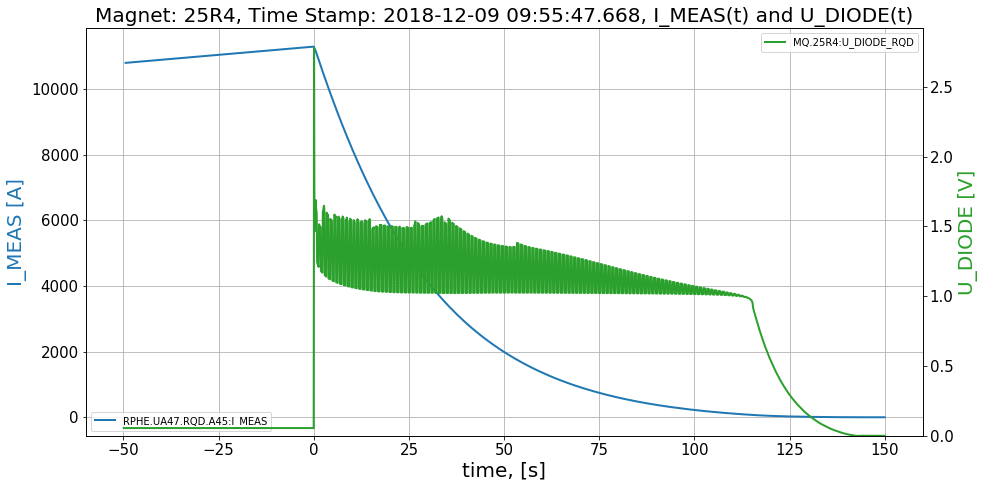

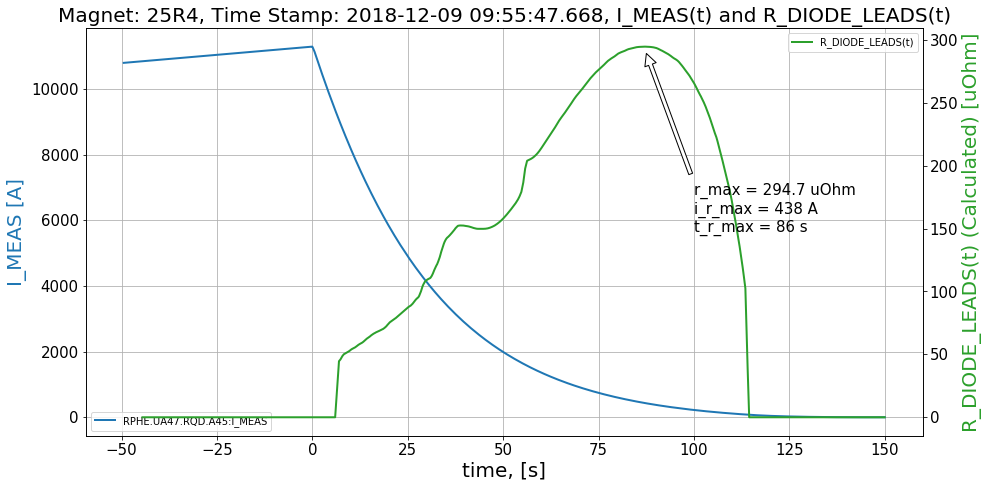

In [4]:
DiodeLeadResistancePlot.plot_current_voltage_cals(magnet, circuit_name, u_diode, timestamp_iqps_qh)
DiodeLeadResistancePlot.plot_current_resistance_cals(magnet, circuit_name, u_diode, timestamp_iqps_qh)

# 3. Post Mortem
## 3.1. Find PM entries
## 3.1.1. For nQPS

In [5]:
system_diode = 'DIODE_RB' if 'RB' in circuit_type else 'DIODE_RQD'
timestamp_nqps = DiodeLeadResistanceQuery.find_diode_pm_entries(circuit_type, circuit_name, system_diode, magnet, timestamp_iqps_qh)
print("Related nQPS PMs around {}: {}".format(timestamp_iqps_qh, len(timestamp_nqps)))
print(timestamp_nqps)

Related nQPS PMs around 2018-12-09 09:55:47.668: 2
[1544345747676000000, 1544345747677000000]


## 3.1.2. For FGC

In [14]:
timestamp_fgc = DiodeLeadResistanceQuery.find_pc_pm_entries(circuit_type, circuit_name, timestamp_iqps_qh)
print("Related FGC PMs around {}: {}".format(timestamp_iqps_qh, len(timestamp_fgc)))
print(timestamp_fgc)

Related FGC PMs around 2018-12-09 09:55:47.668: 1
[1544345747700000000]


## 3.2. Calculate Resistance

In [15]:
# I_A
iab_i_a = DiodeLeadResistanceQuery.query_iab_i_a(circuit_type, circuit_name, timestamp_fgc[0])
# U_DIODE
u_diode_a = DiodeLeadResistanceQuery.query_u_diode(circuit_type, circuit_name, magnet, timestamp_nqps[0])
u_diode_b = DiodeLeadResistanceQuery.query_u_diode(circuit_type, circuit_name, magnet, timestamp_nqps[1])
# U_REF
u_ref = DiodeLeadResistanceQuery.query_u_ref(circuit_type, circuit_name, magnet, timestamp_nqps[0])
# Calculate resistance
res_df = DiodeLeadResistanceAnalysis.calculate_resistance_pm(iab_i_a, u_diode_a, u_diode_b, u_ref, timestamp_iqps_qh, time_corr=0.0)

## 3.3. Plot

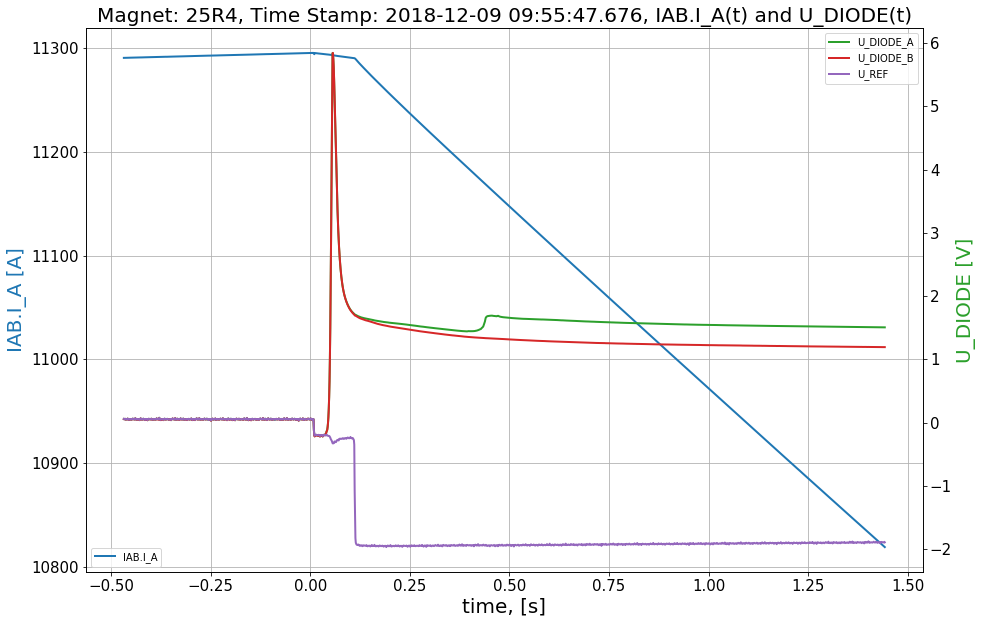

In [16]:
DiodeLeadResistancePlot.plot_current_voltage_pm(magnet, res_df, timestamp_nqps[0])
DiodeLeadResistancePlot.plot_current_resistance_pm(circuit_name, magnet, res_df, timestamp_nqps[0])